In [1]:
from IPython.display import Image
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# hold out validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)


## Cross Validation

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_k, best_score = -1, -1
clfs = {}

# hyperparameter tuning
for k in range(5, 15): 
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print('[{}-NN]\nValidation accuracy: {}'.format(k, score))
    if score > best_score:
        best_k, best_score = k, score
    clfs[k] = pipe
    
# performance reporting
y_pred= clfs[best_k].predict(X_test)
print('\nTest accuracy: %.2f (n_neighbors=%d selected by the holdout method)' % 
      (accuracy_score(y_test, y_pred), best_k))

[5-NN]
Validation accuracy: 0.9375
[6-NN]
Validation accuracy: 0.9375
[7-NN]
Validation accuracy: 0.96875
[8-NN]
Validation accuracy: 0.9375
[9-NN]
Validation accuracy: 0.90625
[10-NN]
Validation accuracy: 0.9375
[11-NN]
Validation accuracy: 0.9375
[12-NN]
Validation accuracy: 0.9375
[13-NN]
Validation accuracy: 0.9375
[14-NN]
Validation accuracy: 0.9375

Test accuracy: 0.91 (n_neighbors=7 selected by the holdout method)


In [7]:
y_pred= clfs[7].predict(X_test)
print('Test accuracy: %.2f (n_neighbors=7 selected manually)' % 
      accuracy_score(y_test, y_pred))

Test accuracy: 0.91 (n_neighbors=7 selected manually)


In [35]:
from sklearn.model_selection import cross_val_score

iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [18]:
best_k, best_score = -1, -1
clfs = {}

for k in range(5, 16): # experiment different hyperparameter
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    # K-Fold CV
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
    if scores.mean() > best_score:
        best_k, best_score = k, scores.mean()
    clfs[k] = pipe

[5-NN]
Validation accuracy: 0.923 [ 0.95652174  0.90909091  0.85        0.95        0.95      ]
[6-NN]
Validation accuracy: 0.896 [ 0.91304348  0.81818182  0.9         0.9         0.95      ]
[7-NN]
Validation accuracy: 0.904 [ 0.95652174  0.86363636  0.8         0.95        0.95      ]
[8-NN]
Validation accuracy: 0.895 [ 0.95652174  0.81818182  0.8         0.95        0.95      ]
[9-NN]
Validation accuracy: 0.904 [ 0.95652174  0.86363636  0.8         0.95        0.95      ]
[10-NN]
Validation accuracy: 0.914 [ 0.95652174  0.86363636  0.8         0.95        1.        ]
[11-NN]
Validation accuracy: 0.884 [ 0.95652174  0.86363636  0.8         0.9         0.9       ]
[12-NN]
Validation accuracy: 0.875 [ 0.91304348  0.86363636  0.85        0.85        0.9       ]
[13-NN]
Validation accuracy: 0.875 [ 0.91304348  0.86363636  0.8         0.9         0.9       ]
[14-NN]
Validation accuracy: 0.915 [ 0.91304348  0.86363636  0.9         0.9         1.        ]
[15-NN]
Validation accuracy: 0.914 

In [19]:
best_clf = clfs[best_k]
best_clf.fit(X_train, y_train)

# performance reporting
y_pred = best_clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=%d selected by 5-fold CV)' % 
      (accuracy_score(y_test, y_pred), best_k))

Test accuracy: 0.93 (n_neighbors=5 selected by 5-fold CV)


In [22]:
from sklearn.model_selection import KFold

outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)): 
    print('[Outer fold %d/10]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in range(1, 15):
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(X_train, y_train):
            X_itrain, X_val = X_train[itrain_idx], X_train[val_idx]
            y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf', KNeighborsClassifier(n_neighbors=k)]])
            pipe.fit(X_itrain, y_itrain)
            
            y_pred = pipe.predict(X_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/10]
Test accuracy: 0.93 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 2/10]
Test accuracy: 0.93 (n_neighbors=4 selected by inner 10-fold CV)
[Outer fold 3/10]
Test accuracy: 0.93 (n_neighbors=5 selected by inner 10-fold CV)
[Outer fold 4/10]
Test accuracy: 0.93 (n_neighbors=5 selected by inner 10-fold CV)
[Outer fold 5/10]
Test accuracy: 0.80 (n_neighbors=8 selected by inner 10-fold CV)
[Outer fold 6/10]
Test accuracy: 0.93 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 7/10]
Test accuracy: 0.87 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 8/10]
Test accuracy: 0.93 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 9/10]
Test accuracy: 1.00 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 10/10]
Test accuracy: 0.93 (n_neighbors=5 selected by inner 10-fold CV)

Test accuracy: 0.92 (5x10 nested CV)


In [28]:
from sklearn.model_selection import GridSearchCV

outer_cv = KFold(n_splits = 20, shuffle=True, random_state=1)
inner_cv = KFold(n_splits = 10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/20]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_neighbors': range(1, 15)}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/20]
Test accuracy: 0.88 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 2/20]
Test accuracy: 1.00 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 3/20]
Test accuracy: 0.88 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 4/20]
Test accuracy: 0.88 (n_neighbors=7 selected by inner 10-fold CV)
[Outer fold 5/20]
Test accuracy: 1.00 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 6/20]
Test accuracy: 0.88 (n_neighbors=5 selected by inner 10-fold CV)
[Outer fold 7/20]
Test accuracy: 1.00 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 8/20]
Test accuracy: 0.88 (n_neighbors=10 selected by inner 10-fold CV)
[Outer fold 9/20]
Test accuracy: 1.00 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 10/20]
Test accuracy: 0.88 (n_neighbors=5 selected by inner 10-fold CV)
[Outer fold 11/20]
Test accuracy: 0.86 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 12/20]
Test accuracy: 1.00 (n_neighbors=5 selected by inner 10-fold CV)


## Voting

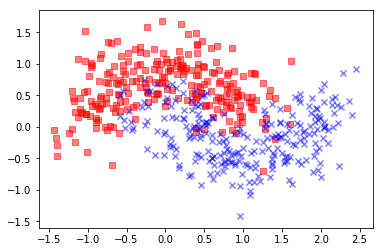

In [37]:
#import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Class 0',
            c='r', marker='s', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1',
            c='b', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1],
            c='', marker='o', label='Class 1')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C=10, random_state=0)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth=3, random_state=0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=5)]])

In [41]:
from sklearn.model_selection import cross_val_score

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.929 (+/- 0.029)
DecisionTree: 0.941 (+/- 0.023)
KNN: 0.948 (+/- 0.026)


In [42]:
from sklearn.ensemble import VotingClassifier
import itertools

print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator = clf, X = X_train, y = y_train,
                             cv = 10, scoring = 'roc_auc')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.959 (+/- 0.021)
(0, 2, 1): 0.960 (+/- 0.019)
(1, 0, 2): 0.958 (+/- 0.023)
(1, 2, 0): 0.944 (+/- 0.025)
(2, 0, 1): 0.948 (+/- 0.023)
(2, 1, 0): 0.939 (+/- 0.025)

Best (0, 2, 1): 0.960


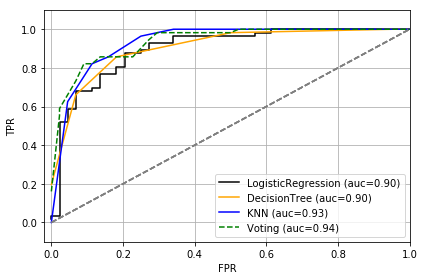

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

clf_labels =['LogisticRegression', 'DecisionTree', 'KNN', 'Voting']
colors = ['black', 'orange', 'blue', 'green']
linestyles = ['-', '-', '-', '--']
for clf, label, clr, ls in zip([pipe1, pipe2, pipe3, best_vt], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 1])
    plt.ylim([-0.1, 1.1])
    plt.grid()
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plt.grid()
plt.tight_layout()
#plt.savefig('./output/fig-vote-roc.png', dpi=300)
plt.show()

In [45]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')


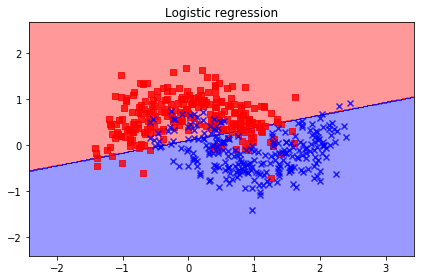

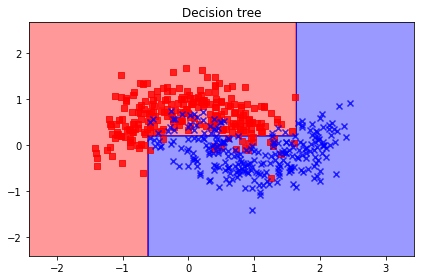

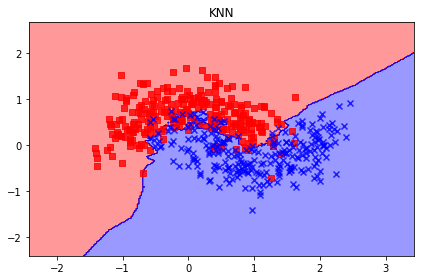

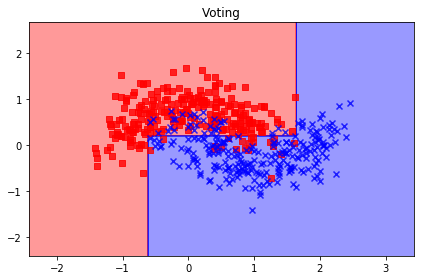

In [46]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X = X_combined, y = y_combined, 
                      classifier = pipe1,
                      test_idx = range(len(y_train),
                                       len(y_train) + len(y_test)))
plt.title('Logistic regression')
plt.tight_layout()
#plt.savefig('./output/fig-vote-logistic-regressio-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe2,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
#plt.savefig('./output/fig-vote-decision-tree-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe3,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
#plt.savefig('./output/fig-voting-knn-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
#plt.savefig('./output/fig-voting-boundary.png', dpi=300)
plt.show()

## Bagging

In [48]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

In [49]:
from sklearn.metrics import accuracy_score

# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.840
[Bagging] auc-train = 0.993, auc-test = 0.860


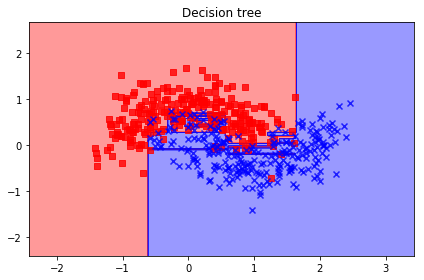

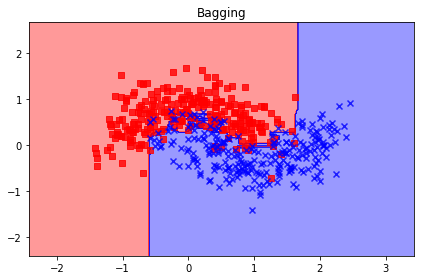

In [52]:
import numpy as np
import matplotlib.pyplot as plt

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
#plt.savefig('./output/fig-bagging-decision-tree-boundary.png', dpi=300)
plt.show()


plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging')
plt.tight_layout()
#plt.savefig('./output/fig-bagging-boundary.png', dpi=300)
plt.show()

#plot_decision_regions(X=X_combined, y=y_combined, 
#                      classifier=bag, soft=True,
#                      test_idx=range(len(y_train), 
#                                     len(y_train) + len(y_test)))
#plt.title('Bagging (soft)')
#plt.tight_layout()
#plt.savefig('./output/fig-bagging-boundary-soft.png', dpi=300)
#plt.show()

## AdaBoosting

In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator = tree, n_estimators = 500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[DecisionTree] accuracy-train = 0.838, accuracy-test = 0.710
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.870


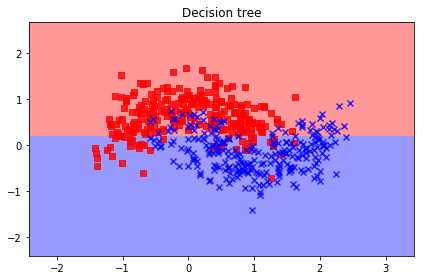

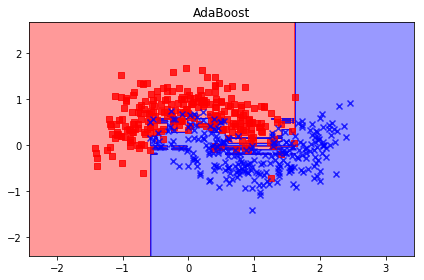

In [61]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost')
plt.tight_layout()
#plt.savefig('./output/fig-adaboost-boundary.png', dpi=300)
plt.show()

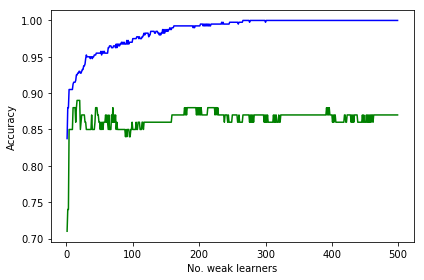

In [62]:
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
    ada = AdaBoostClassifier(base_estimator = tree, n_estimators = i, 
                             learning_rate = 1, random_state = 1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y_train, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))
        
plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
#plt.savefig('./output/fig-adaboost-acc.png', dpi=300)
plt.show()


[AdaBoost16] accuracy-train = 0.925, accuracy-test = 0.890


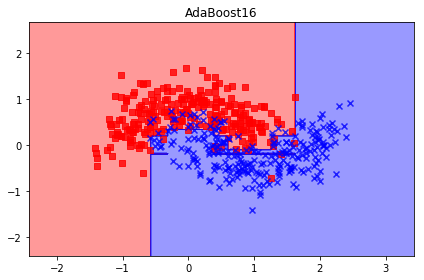

In [64]:
ada16 = AdaBoostClassifier(base_estimator = tree, n_estimators = 16)
ada16.fit(X_train, y_train)
y_train_pred = ada16.predict(X_train)
y_test_pred = ada16.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost16] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost16')
plt.tight_layout()
#plt.savefig('./output/fig-adaboost16-boundary.png', dpi=300)
plt.show()

## Compare with Voting, Bagging and AdaBoosting

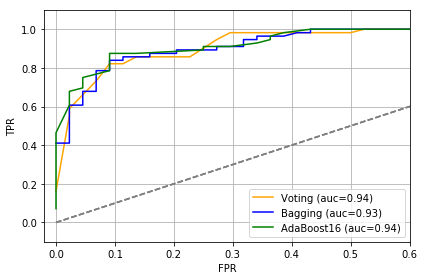

In [67]:
clf_labels =['Voting', 'Bagging', 'AdaBoost16']
colors = ['orange', 'blue', 'green']
linestyles = ['-', '-', '-']
for clf, label, clr, ls in zip([best_vt, bag, ada16], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color = clr, linestyle = ls, label = '%s (auc=%0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 0.6])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plt.grid()
plt.tight_layout()
#plt.savefig('./output/fig-ensemble-roc.png', dpi=300)
plt.show()